In [1]:
import scanpy as sc
import numpy as np
import scprep
from anndata import AnnData
import phate
from phate.cluster import kmeans
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import magic

In [2]:
datapath_mtg = '/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/data/SEA-AD/MTG/RNAseq/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad'
# Load the file
adata = sc.read_h5ad(datapath_mtg, backed='r')

In [3]:
# adata.obs['Braak'].value_counts()

In [4]:
np.random.seed(42)
n_cells_per_braak = 2000

# Get unique Braak stages
unique_braak_stages = adata.obs['Braak'].unique()

# Subsample cells from each Braak stage
subsampled_cells = []
for braak_stage in unique_braak_stages:
    cells_in_braak = adata.obs_names[adata.obs['Braak'] == braak_stage]
    n_cells_to_sample = min(n_cells_per_braak, len(cells_in_braak))  # Adjust if a Braak stage has fewer cells
    subsampled_cells.extend(np.random.choice(cells_in_braak, size=n_cells_to_sample, replace=False))

# Create a subsampled AnnData object
adata_subset = adata[subsampled_cells, :]

In [5]:
# # subest with stratified sampling
# # Calculate the proportion of each group
# adata.obs['combined_key'] = adata.obs['Braak'].astype(str) + '_' + adata.obs['Class'].astype(str) + '_' + adata.obs['Subclass'].astype(str)
# group_proportions = adata.obs['combined_key'].value_counts(normalize=True)

# # Calculate the number of cells to sample from each group
# total_cells_to_sample = 10000  # total number of cells you want in the subsample
# group_sample_sizes = (group_proportions * total_cells_to_sample).round().astype(int)

# # Subsample cells from each group
# subsampled_cells = []
# for group, n_cells in group_sample_sizes.items():
#     cells_in_group = adata.obs_names[adata.obs['combined_key'] == group]
#     subsampled_cells.extend(np.random.choice(cells_in_group, size=n_cells, replace=False))

# # Create subsampled AnnData object
# adata_subset = adata[subsampled_cells, :]

In [6]:
datasetname = 'MTG'
# adata_subset = adata_mtg[:, :]

In [7]:
# Preprocessing
data_preproc = adata_subset.X
data_preproc, obs_preproc = scprep.filter.filter_library_size(data_preproc, adata_subset.obs, cutoff=2000)
data_preproc, var_preproc = scprep.filter.filter_rare_genes(data_preproc, adata_subset.var.T, min_cells=10)
data_preproc = scprep.normalize.library_size_normalize(data_preproc)
data_preproc = scprep.transform.sqrt(data_preproc)
var_preproc = var_preproc.T
var_preproc = pd.DataFrame(var_preproc)

In [8]:
# Store as New AnnData
adata_new = AnnData(X=data_preproc, obs=obs_preproc, var=var_preproc)
# sc.tl.pca(adata_new, svd_solver='arpack', n_comps=100)
# Batch Removal
# bbknn.bbknn(adata, batch_key='Donor ID')
# sc.external.pp.harmony_integrate(adata_new, key='Donor ID')  # Replace 'batch_key' with your batch column

In [9]:
# # MAGIC
# magic_op = magic.MAGIC()
# X_magic = magic_op.fit_transform(adata_new.X)
# adata_new.obsm['X_magic'] = X_magic

In [10]:
adata_new

AnnData object with n_obs × n_vars = 14000 × 30765
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mont

In [11]:
# PHATE
phate_op_preproc = phate.PHATE(n_components=3)
X_phate = phate_op_preproc.fit_transform(adata_new.X)
adata_new.obsm['X_phate'] = X_phate

Calculating PHATE...
  Running PHATE on 14000 observations and 30765 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 44.85 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.69 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 60.63 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.81 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.18 seconds.
  Calculated landmark operator in 7.99 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 3.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.22 seconds.
  Calculating metric MDS...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 60.43 seconds.
Calculated PHATE in 133.72 seconds.


<Figure size 2500x2000 with 0 Axes>

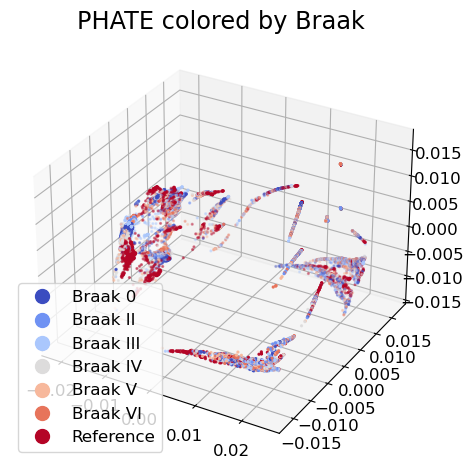

In [12]:
# Plot the clusters
fig = plt.figure(figsize=(25, 20))
scprep.plot.scatter3d(adata_new.obsm['X_phate'], 
                        title=f'PHATE colored by Braak', 
                        c=adata_new.obs["Braak"], cmap='coolwarm', 
                        legend_title='', legend_loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 640x480 with 0 Axes>

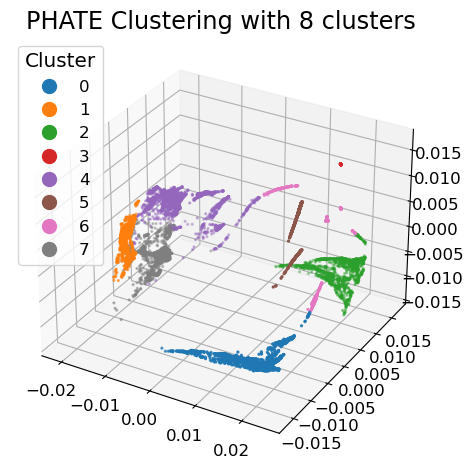

In [13]:
# Clustering
phate_cluster_labels = kmeans(phate_op_preproc, n_clusters=8)
adata_new.obs["phate_cluster"] = pd.Series(phate_cluster_labels, index=adata_new.obs.index).astype('category')

# Plot the clusters
plt.figure()
scprep.plot.scatter3d(adata_new.obsm['X_phate'], 
                        title=f'PHATE Clustering with 8 clusters', 
                        c=phate_cluster_labels, cmap='tab10', 
                        legend_title='Cluster')
plt.tight_layout()
# plt.show()


In [14]:
adata_new.obs["Braak"].value_counts()

Reference    2000
Braak 0      2000
Braak II     2000
Braak III    2000
Braak IV     2000
Braak V      2000
Braak VI     2000
Name: Braak, dtype: int64

<Figure size 2500x2000 with 0 Axes>

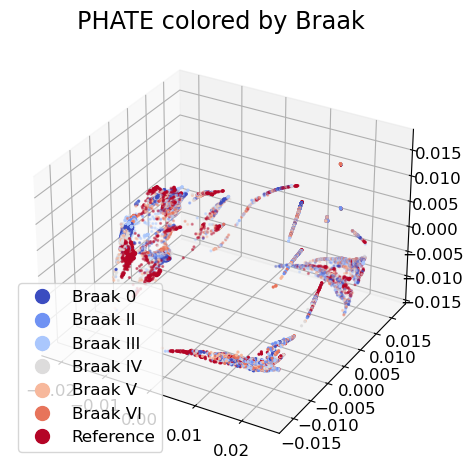

In [15]:
# Plot the clusters
fig = plt.figure(figsize=(25, 20))
scprep.plot.scatter3d(adata_new.obsm['X_phate'], 
                        title=f'PHATE colored by Braak', 
                        c=adata_new.obs["Braak"], cmap='coolwarm', 
                        legend_title='', legend_loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()


In [16]:
# Differential Expression
sc.tl.rank_genes_groups(adata_new, groupby='phate_cluster', method='t-test')

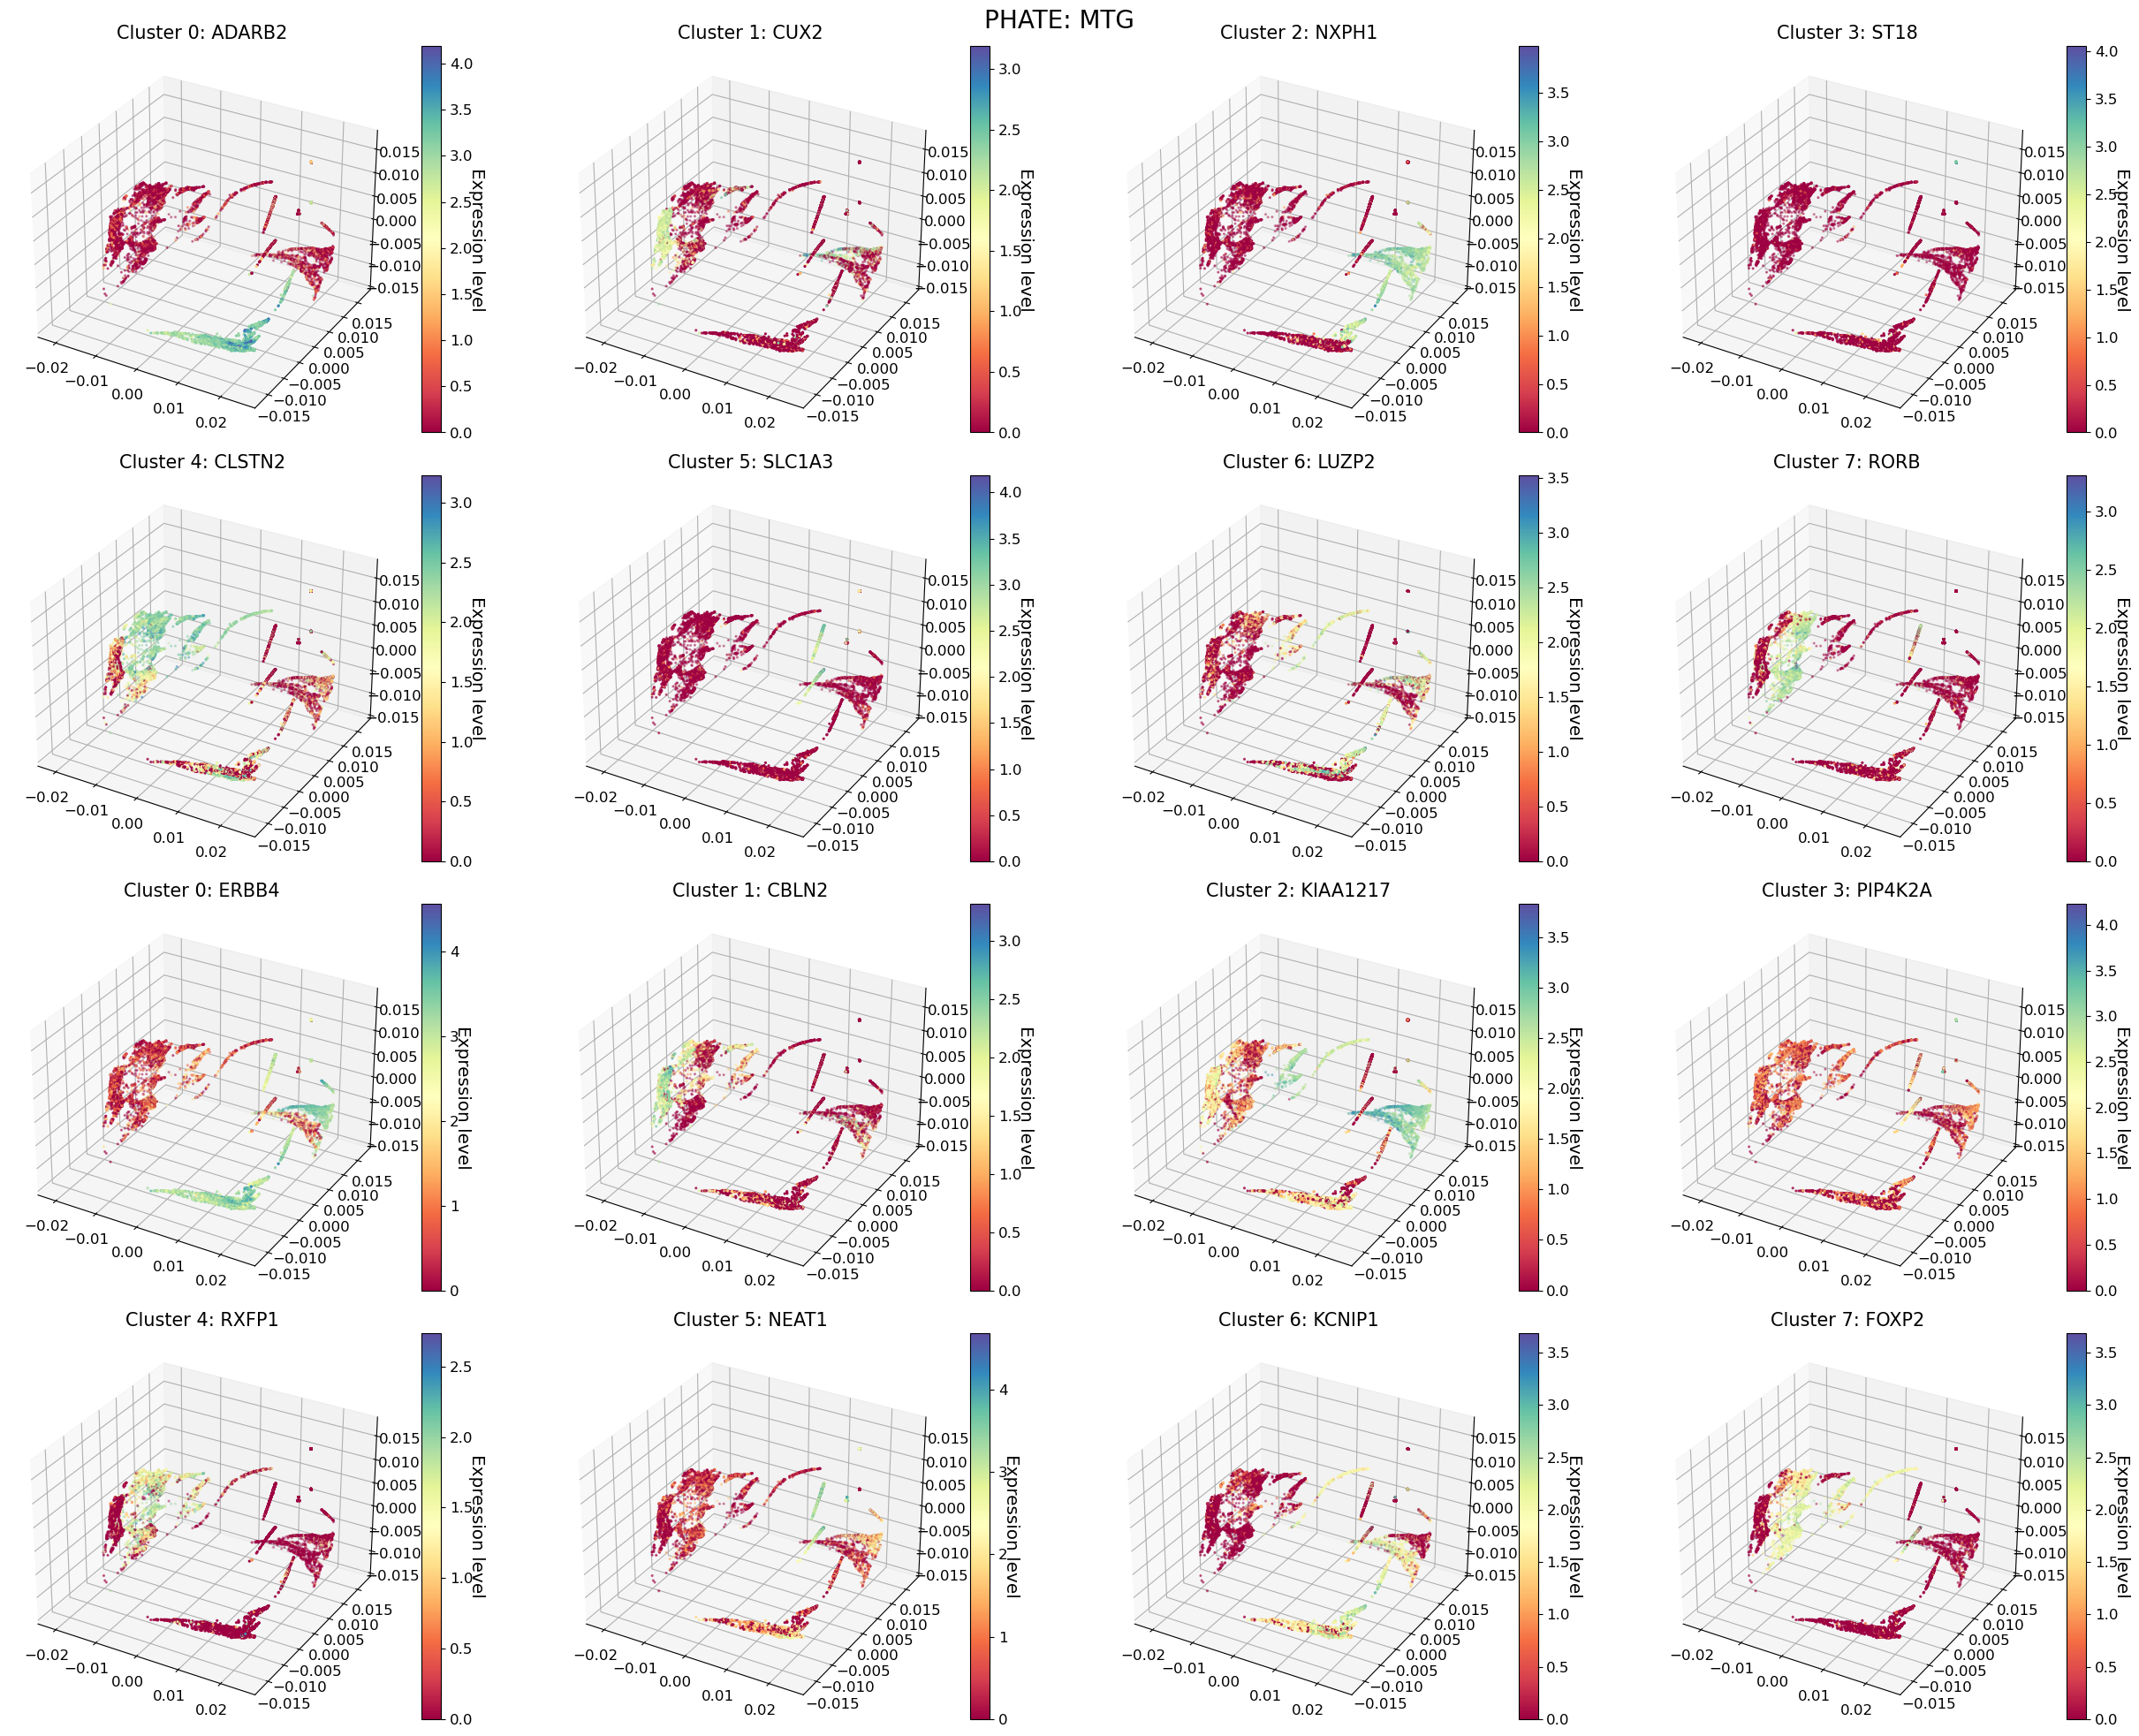

In [17]:
# Plot the DEGs
top_genes = adata_new.uns['rank_genes_groups']['names']
selected_genes = list(top_genes[0]) + list(top_genes[1])
selected_clusters = [i for i in range(8)] + [i for i in range(8)]

# Set up the matplotlib figure and axes for a 4x4 grid
fig = plt.figure(figsize=(25, 20))
axs = [fig.add_subplot(4, 4, i+1, projection='3d') for i in range(16)]

# Flatten the axs array for easier indexing

# Loop through each marker and plot
plot_index = 0
for cluster, gene_name in zip(selected_clusters, selected_genes):
    marker_id = adata_new.var_names.get_loc(gene_name)
    marker_level = adata_new[:, marker_id].X.toarray().flatten()
    
    # Plot each marker gene in its respective subplot
    ax = axs[plot_index]
    
    scprep.plot.scatter3d(adata_new.obsm['X_phate'], 
                        c=marker_level, cmap='Spectral', 
                        ax=ax,
                        legend_title='Expression level')


    # sc.pl.scatter(adata_new, basis='phate', color=gene_name, ax=ax, show=False, 
                #   title=f'{gene_name}')
    ax.set_title(f'Cluster {cluster}: {gene_name}', fontsize=15)
    
    plot_index += 1
# plt.subplots_adjust(right=0.85)
# Add a main title and adjust the layout
fig.suptitle(f'PHATE: {datasetname}', fontsize=20)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rectangle in which to fit the subplots
plt.tight_layout()
# Show the plot
plt.show()

In [18]:
# save the adata
save_path = './adata_sea_ad_mtg_rna_phate.h5ad'
adata_new.write(save_path)

: 